In [14]:
from matplotlib import pyplot as plot
from itertools import product
from tqdm import tqdm

from scipy.stats import gamma
from random import sample
import numpy, ray, gc

%matplotlib inline

In [2]:
ray.init()

2019-12-05 23:22:53,791	WARNING worker.py:1268 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2019-12-05 23:22:53,809	INFO resource_spec.py:205 -- Starting Ray with 0.44 GiB memory available for workers and up to 0.22 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


{'node_ip_address': '192.168.42.2',
 'redis_address': '192.168.42.2:31829',
 'object_store_address': '/tmp/ray/session_2019-12-05_23-22-53_801159_13488/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2019-12-05_23-22-53_801159_13488/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2019-12-05_23-22-53_801159_13488'}

In [3]:
# Standard differentially-private schemes

def gaussian_noise(location, epsilon):
    return location + numpy.random.normal(loc = [0, 0], scale = 1 / epsilon )

def laplacian_noise(location, epsilon):
    return location + numpy.random.laplace(loc = [0, 0], scale = 1 / epsilon )

def geo_noise(location, epsilon):
    theta, r = numpy.random.uniform(0, 2 * numpy.pi), gamma.ppf( numpy.random.uniform(0, 1), 2, scale = (1 / epsilon) )
    x, y = r * numpy.cos(theta), r * numpy.sin(theta)
    return location + numpy.array([x, y])

# An extension of k-anonymity
def cloaking(location, epsilon):
    x, y = location
    return ( x // 5, y // 5 )

In [4]:
privacy_schemes = {
    "Gaussian": gaussian_noise,
    "Laplacian": laplacian_noise,
    
    "Geo-Indistinguishability": geo_noise,
    "Cloaking": cloaking
}

In [5]:
def distance(location, center):
    x, y = location
    a, b = center
    return numpy.sqrt( (x - a)**2 + (y - b)**2 )

# We assume users can be modeled as having some distribution over locations, 
# which is centered at some "home" but is non-deterministic (ie., noisy)

class user:
    def __init__(self, server):
        self.space = server.space
        self.location_distr = self.centered_distribution()
        self.location_distr = self.location_distr / numpy.sum(self.location_distr)
        
    def centered_distribution(self):
        center  = self.space[ numpy.random.randint(0, len(self.space)) ]
        initial = [ numpy.random.uniform(0, 2) / (distance(L, center) + 1) for L in self.space ]
        return numpy.round( numpy.array( initial ) / numpy.sum( initial ), decimals = 3 )
        
    def sample(self, epochs):
        index = numpy.random.choice( len(self.space), size = epochs, p = self.location_distr )
        return [ self.space[i] for i in index ]

In [6]:
class server:
    def __init__(self, length = 75, count = 100, epochs = 250):
        self.space = product(range(length), repeat = 2 )
        self.space = list( map(tuple, self.space) )
        
        self.users = [ user(self) for i in tqdm(range(count)) ]
        self.length, self.epochs = length * length, epochs
        
        self.samples = [ u.sample(epochs) for u in tqdm(self.users) ]
        self.noisy_samples = {}
        
    def regularize_users(self, repetition):
        self.samples = [ s * repetition for s in self.samples ]
        
    def average_accuracy(self, scheme):
        
        
    def accuracy(self, scheme, center, noisy_center:)
        disjoint = lambda x, y: 1 if (x < 10 and y > 10) or (x > 10 and y < 10) else 0
        
        locations = zip( zip(* self.samples)[epoch], zip(* self.noisy_samples[scheme])[epoch] )
        disjuctive = [ disjoint( distance(x, center), distance(y, noisy_center) ) for x, y in locations ]
        return sum(disjunctive)
        
    def introduce_privacy(self, epsilon):
        for scheme in privacy_schemes:
            noise = privacy_schemes[ scheme ]
            
            heartbeats = [ self.noisy_user(u, noise, epsilon) for u in tqdm(self.samples) ]            
            self.noisy_samples[ scheme ] = heartbeats
    
    def noisy_user(self, user, noise, epsilon):
        return [ tuple(numpy.round( noise(location, epsilon) )) for location in user ]

In [ ]:
class semi_honest(server):
    def average_predictive_power(self, scheme):
        results = [ self.noisy_estimates(scheme, i) for i in range(len(self.samples)) ]
        return numpy.mean( results, axis = 0 )
    
    def noisy_estimates(self, scheme, user):
        user_heartbeats = self.noisy_samples[scheme][user]
        estimates = [ numpy.array([ 1 if user_heartbeats[0] == x else 0 for x in self.space ]) ]

        for i in range(1, self.epochs):
            if user_heartbeats[i] in self.space:
                estimates.append( self.update_MLE(estimates[-1], user_heartbeats[i], i) )
            else:
                estimates.append( estimates[-1] )

        true = self.users[user].location_distr
        return numpy.fromiter( map( lambda x: self.bhattacharyya(x, true), estimates ), dtype = float )
        
    def update_MLE(self, distribution, heartbeat, epoch):
        index = self.space.index( user_heartbeats[i] )

        previous = distribution * epoch
        previous[index] = previous[index] + 1
        
        return previous / sum(previous)
        
    def bhattacharyya(self, estimate, true):
        return numpy.sum(numpy.sqrt(estimate * true))

In [7]:
@ray.remote
def evaluate(server, scheme):
    return server.average_predictive_power(scheme), scheme

def compare_schemes(server, save = False):
    endogenous = range(server.epochs)
    _exogenous = ray.get([ evaluate.remote(server, scheme) for scheme in privacy_schemes ])
    
    for exogenous, scheme in _exogenous:
        plot.plot(endogenous, exogenous, label = scheme)

    plot.legend()
    plot.savefig(save) if save else plot.show()

In [11]:
USGS = semi_honest(length = 100, count = 100, epochs = 500)

100%|██████████| 100/100 [00:00<00:00, 1301.10it/s]


In [12]:
USGS.introduce_privacy(0.025)

100%|██████████| 100/100 [00:00<00:00, 139.04it/s]


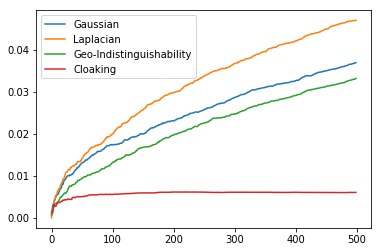

In [13]:
compare_schemes(USGS)